In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd
from astropy.time import Time
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from astropy.timeseries import TimeSeries
from numpy import random
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel, Matern, DotProduct

In [3]:
f_kepler = 'kplr008480662-2011271113734_llc.fits'

## Load data

In [4]:
d_k = TimeSeries.read(f_kepler, format='kepler.fits')
d_k

/opt/anaconda3/lib/python3.9/site-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 82 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')


time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2011-06-27T08:18:25.757,2.698625e-03,39049,4.9164937e+03,3.5327988e+00,1.1718889e+03,3.9866829e-01,nan,nan,0,nan,nan,nan,nan,640.75243,1.1129254e-03,699.91289,1.1058644e-03,-5.9441756e-02,8.4912792e-02
2011-06-27T08:47:51.269,2.699093e-03,39050,4.9128486e+03,3.5324652e+00,1.1713184e+03,3.9867067e-01,5.2649253e+03,3.7278571e+00,0,nan,nan,nan,nan,640.75143,1.1124378e-03,699.91592,1.1052547e-03,-5.9286337e-02,8.5012980e-02
2011-06-27T09:17:16.772,2.699562e-03,39051,4.9138765e+03,3.5324528e+00,1.1715013e+03,3.9798385e-01,5.2661558e+03,3.7267749e+00,0,nan,nan,nan,nan,640.75186,1.1140730e-03,699.91505,1.1067697e-03,-5.9284452e-02,8.5256688e-02
2011-06-27T09:46:42.285,2.700030e-03,39052,4.9172529e+03,3.5328438e+00,1.1708405e+03,3.9870054e-01,5.2703213e+03,3.7280977e+00,0,nan,nan,nan,nan,640.74973,1.1129034e-03,699.91577,1.1055456e-03,-5.9436280e-02,8.5689098e-02
2011-06-27T10:16:07.779,2.700498e-03,39053,4.9260264e+03,3.5335283e+00,1.1701185e+03,3.9875081e-01,5.2797461e+03,3.7291028e+00,0,nan,nan,nan,nan,640.75201,1.1097284e-03,699.91612,1.1025920e-03,-5.9374198e-02,8.5697345e-02
2011-06-27T10:45:33.283,2.700966e-03,39054,4.9166216e+03,3.5326972e+00,1.1709368e+03,3.9810404e-01,5.2700088e+03,3.7282333e+00,0,nan,nan,nan,nan,640.75203,1.1127626e-03,699.91789,1.1054026e-03,-5.9354130e-02,8.5718244e-02
2011-06-27T11:14:58.795,2.701434e-03,39055,4.9237241e+03,3.5333383e+00,1.1710035e+03,3.9865297e-01,5.2775557e+03,3.7284195e+00,0,nan,nan,nan,nan,640.75460,1.1108209e-03,699.91654,1.1038701e-03,-5.9355170e-02,8.5560627e-02
2011-06-27T11:44:24.290,2.701901e-03,39056,4.9166108e+03,3.5328085e+00,1.1710837e+03,3.9839542e-01,5.2701631e+03,3.7287343e+00,0,nan,nan,nan,nan,640.75172,1.1129025e-03,699.91552,1.1057109e-03,-5.9377823e-02,8.5331567e-02


In [5]:
time = np.array(d_k.time.jd)
sap_flux = np.array(d_k['sap_flux'])
sap_flux_err = np.array(d_k['sap_flux_err'])

In [6]:
### Removing 'nan' values
index = np.argwhere(np.isnan(sap_flux))
sap_flux = np.delete(sap_flux,index)
time = np.delete(time,index)
sap_flux_err = np.delete(sap_flux_err,index)

In [7]:
###  Defining initial time at the Time of Shock Breakout (used to shift the Light Curve to 0 wrt shock breakout)
initial_time_index = 1320 # index of the t_sbo
initial_time = d_k.time.jd[initial_time_index]
print ("time of shock break out = ", initial_time)

time of shock break out =  2455766.818909073


In [8]:
### Finding the peak luminosity index and corresponding time
peak_lum_index = np.argmax(sap_flux)
peak_lum_time = time[peak_lum_index]
print ("time of Peak lum = ", peak_lum_time)

time of Peak lum =  2455774.440683991


In [9]:
### Rise time of Kepler
rise_time_Kepler = peak_lum_time- initial_time
print("Rise time of Kepler estimated by eye =", rise_time_Kepler)

Rise time of Kepler estimated by eye = 7.621774918399751


In [10]:
### Unnormalized Kepler slope at shock breakout and plot (before we normalize the luminosity between 0 and 1)
kepler_scale = 1.879
Kep_slope = kepler_scale*(sap_flux[peak_lum_index]-sap_flux[initial_time_index])/rise_time_Kepler # 1.879 scaling factor for better estimate of the first derivative
print("Unnormalized Kepler slope at shock breakout found visually from the graph = ", Kep_slope)

Unnormalized Kepler slope at shock breakout found visually from the graph =  50.1342888914945


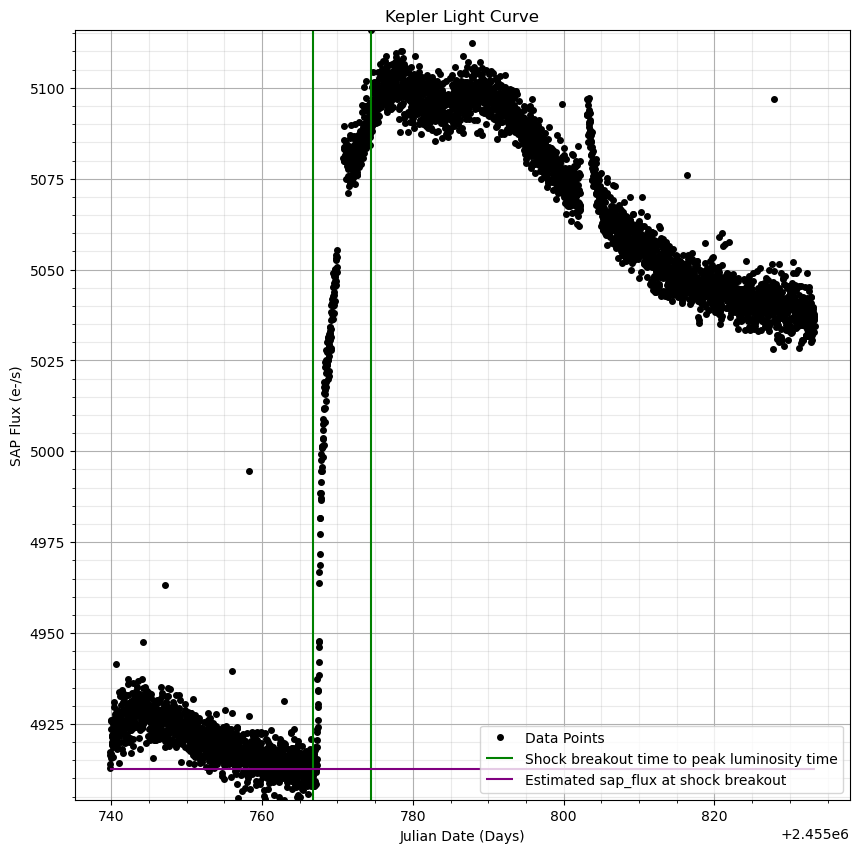

In [11]:
### Kepler data plot showing the slope
fig, ax = plt.subplots(1,1,figsize=([10,10]))
ax.plot(time, sap_flux, '.', markersize = 8, color = 'black', label = 'Data Points')
#ax.errorbar(time, sap_flux, yerr = sap_flux_err, color = 'blue', label = 'Uncertainty Bars', alpha=0.25) 
plt.vlines(initial_time, np.min(sap_flux), np.max(sap_flux), color='green', label='Shock breakout time to peak luminosity time')
plt.vlines(peak_lum_time, np.min(sap_flux), np.max(sap_flux), color='green')
plt.hlines(sap_flux[initial_time_index], np.min(time), np.max(time), color='purple', label='Estimated sap_flux at shock breakout')
#plt.plot([initial_time, time[peak_lum_index]],[sap_flux[initial_time_index], sap_flux[initial_time_index] + Kep_slope*rise_time_Kepler], color='magenta', label='First derivative at shock-breakout')
ax.set_xlabel('Julian Date (Days)')
ax.set_ylabel('SAP Flux (e-/s)')
ax.set_ylim(np.min(sap_flux), np.max(sap_flux))
ax.set_title('Kepler Light Curve')
ax.grid(which = "both")
ax.minorticks_on()
ax.grid( which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.legend(loc = "lower right")
plt.savefig('Kepler_data_original.png', dpi = 150, bbox_inches = "tight")
plt.show()
plt.close() 

In [13]:
B = sap_flux[initial_time_index]/np.max(sap_flux) #<====== estimated sap_flux at the time of shock breakout 

In [41]:
plt.plot(time_1, sap_flux_1/np.max(sap_flux),'.', color = 'red', label = 'Data Points Chosen') 
plt.xlabel('Julian Date (Days)')
plt.ylabel('SAP Flux Normalized (e-/s)')
plt.grid()

NameError: name 'time_1' is not defined

## fit with GPR: initial time + 20

In [20]:
### Selected interval for time and flux 
time_index_2 = 22 # change
end_times = []
time_end_index = 1100
end_index = initial_time_index+time_index_2+time_end_index # 
time_2 = time[initial_time_index + time_index_2 : end_index]
sap_flux_2 = sap_flux[initial_time_index+time_index_2 : end_index]
sap_flux_err_2 = sap_flux_err[initial_time_index+time_index_2: end_index]
### The end of usable dataset index (for the interval for which we'll use the data to fit)
#end_index = random.randint(2500, 2750) # 25.44 days to 30.61 days from initial time
#end_index = 2750

end_times.append(time[end_index]-initial_time)
print ("t_end = ", end_times+initial_time)
print ("It is ",end_times, 'after t_sbo ',initial_time )

t_end =  [2455791.07359972]
It is  [24.25469064572826] after t_sbo  2455766.818909073


In [21]:
time_2[0]-initial_time

0.7560490346513689

In [22]:
time_2[0]

2455767.5749581074

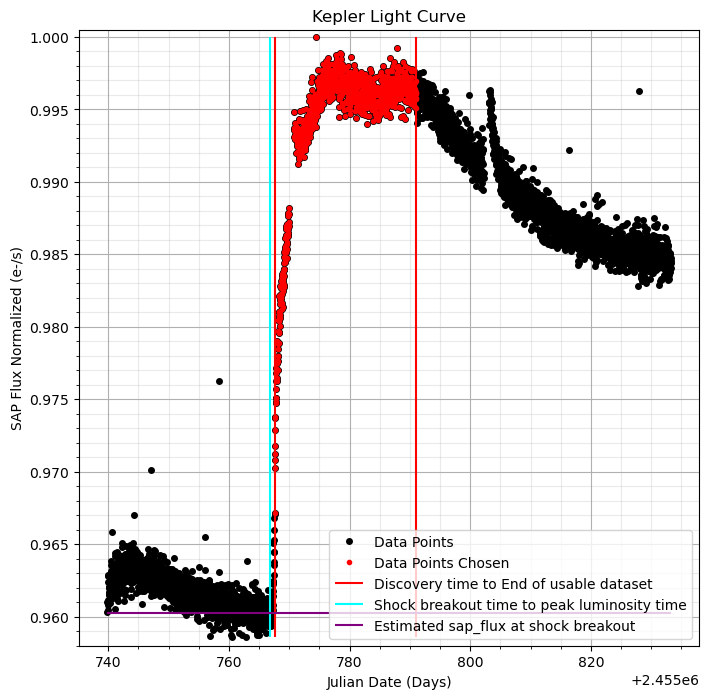

In [23]:
### Kepler data plot showing above decisions visually

fig, ax = plt.subplots(1,1,figsize=([8,8]))
ax.plot(time, sap_flux/np.max(sap_flux), '.', markersize = 8, color = 'black', label = 'Data Points')
#ax.errorbar(time[discovery_time_index : end_index] - initial_time,sap_flux[discovery_time_index : end_index], yerr = yerr, color = 'blue', label = 'Uncertainty Bars', alpha=0.25)
ax.plot(time_2, sap_flux_2/np.max(sap_flux),'.', color = 'red', label = 'Data Points Chosen') 
plt.vlines(time[initial_time_index+time_index_2], np.min(sap_flux/np.max(sap_flux)), 1, color='red', label='Discovery time to End of usable dataset')
plt.vlines(time[end_index], np.min(sap_flux/np.max(sap_flux)), 1, color='red')
plt.vlines(initial_time, np.min(sap_flux/np.max(sap_flux)), 1, color='cyan', label='Shock breakout time to peak luminosity time')
#plt.vlines(peak_lum_time, np.min(sap_flux/np.max(sap_flux)), 1, color='green')
plt.hlines(B, np.min(time), np.max(time), color='purple', label='Estimated sap_flux at shock breakout')
#plt.plot([initial_time, time[peak_lum_index]],[B, B+d*rise_time_Kepler], color='magenta', label='First derivative at shock-breakout')
ax.set_xlabel('Julian Date (Days)')
ax.set_ylabel('SAP Flux Normalized (e-/s)')
ax.set_ylim(0.958,1.0005)
ax.set_title('Kepler Light Curve')
ax.grid(which = "both")
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.legend(loc = "lower right")
plt.savefig('Kepler_data_decisions.png', dpi = 300, bbox_inches = "tight")
plt.show()
plt.close()  

1100


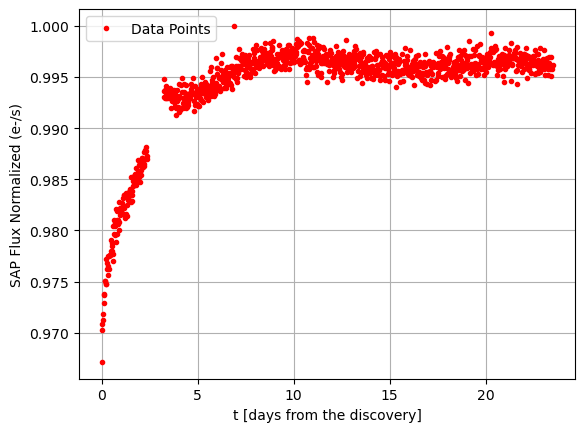

In [24]:
t0 =  time_2.min()
X = time_2 - t0
y = sap_flux_2/np.max(sap_flux)
print (len(X))
plt.plot(X, y,'.', color = 'red', label = 'Data Points') 
plt.xlabel('t [days from the discovery]')
plt.ylabel('SAP Flux Normalized (e-/s)')
plt.legend()
plt.grid()

In [25]:
# ==== Prediction grid ====
X_pred = np.linspace(X.min()-3, X.max()+3, 600).reshape(-1,1)
mjd_pred = X_pred.ravel() + t0

    
X = X.reshape(-1, 1)

In [26]:
def GPR_fit(X,y):
    kernel = (
    DotProduct(sigma_0=1.0) * C(1.0, (1e-3, 1e3)) +
    C(1.0, (1e-3, 1e3)) * Matern(length_scale=3.0, nu=1.5,
                                 length_scale_bounds=(0.05, 100.0)) +
    WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
)


    gpr = GaussianProcessRegressor(kernel=kernel,
                               normalize_y=True,
                               n_restarts_optimizer=5)
    gpr.fit(X, y)
    y_pred, _ = gpr.predict(X_pred, return_std=True)

    return (y_pred)

### single fit

In [27]:
y_pred = GPR_fit(X,y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
ave_BKG = B
t_sbo = mjd_pred[np.argmin(np.abs(y_pred - ave_BKG ))]
mag_sbo = y_pred[np.argmin(np.abs(y_pred - ave_BKG ))]

print ("The predicted shock break out time is ",t_sbo)

The predicted shock break out time is  2455766.8879393903


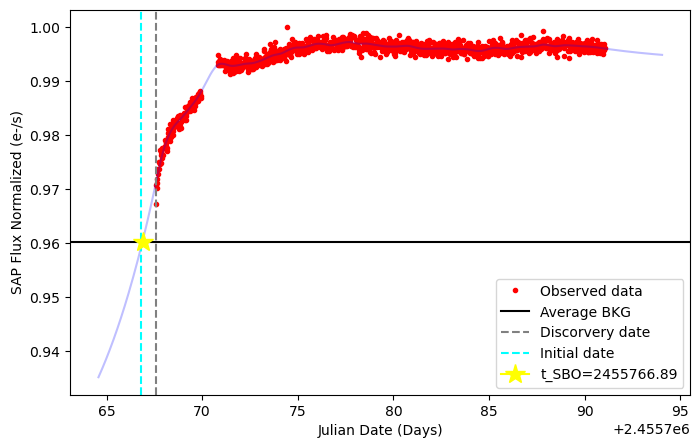

In [29]:
# ==== Plot outside the loop ====
plt.figure(figsize=(8,5))
plt.plot(X+t0, y, 'r.', label='Observed data')
plt.plot(mjd_pred, y_pred, color='blue', alpha=0.25)

plt.axhline(ave_BKG, color='black', linestyle='-',label="Average BKG") 
plt.axvline(time_2[0], color='gray', linestyle='--',label="Discorvery date")
plt.axvline(initial_time, color='cyan', linestyle='--',label="Initial date")
plt.plot (t_sbo,ave_BKG, marker='*', color="yellow",markersize=15, label="t_SBO="+str(t_sbo.round(2)))
plt.xlabel('Julian Date (Days)')
plt.ylabel('SAP Flux Normalized (e-/s)')

plt.legend()

In [30]:
print ("time of shock break out = ", initial_time)

time of shock break out =  2455766.818909073


### jackknife fit

In [31]:
# ==== Jackknife parameters ====
n_iter = 50              # number of jackknife samples
frac_remove = 0.3       # fraction of points to remove each iteration

# ==== Storage lists ====
all_y_pred = []          # to store each run’s y_pred
all_idx_kept = []        # optional: which points were used each run

# ==== Jackknife loop ====
for i in range(n_iter):
    print (i)
    mask = np.ones(len(X), dtype=bool)
    drop_idx = np.random.choice(len(X), size=int(frac_remove*len(X)), replace=False)
    mask[drop_idx] = False

    X_sub, y_sub = X[mask], y[mask]
    all_idx_kept.append(np.where(mask)[0])   # (optional)

    y_pred= GPR_fit(X_sub, y_sub)
    
    all_y_pred.append(y_pred)

0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


3


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


4


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


5


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


7


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


8


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


9


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


11


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


12


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


15


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


17


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


18


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


19


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


21


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


23


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


24


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


25


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


27


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


29


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


31


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


33


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


34


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


35


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


36


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


37


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


39


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


41


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


42


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


43


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


45


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


46


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


47


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


49


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [32]:
# ==== Convert to array for later analysis ====
all_y_pred = np.array(all_y_pred)   # shape (n_iter, len(X_pred))

# ==== Example: compute jackknife mean and std ====
jack_mean = np.mean(all_y_pred, axis=0)
jack_std  = np.std(all_y_pred, axis=0)

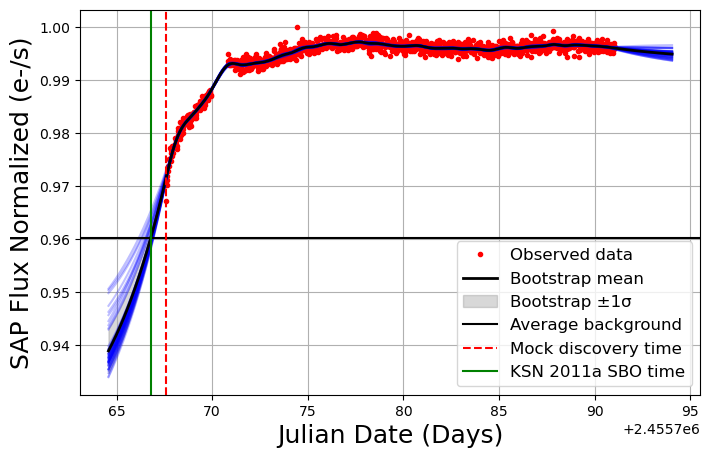

In [38]:
# ==== Plot outside the loop ====
plt.figure(figsize=(8,5))
plt.plot(X+t0, y, 'r.', label='Observed data')
for y_pred in all_y_pred:
    plt.plot(mjd_pred, y_pred, color='blue', alpha=0.25)

plt.plot(mjd_pred, jack_mean, 'k-', lw=2, label='Bootstrap mean')
plt.fill_between(mjd_pred, jack_mean - jack_std, jack_mean + jack_std,
                 color='gray', alpha=0.3, label='Bootstrap ±1σ')

plt.axhline(ave_BKG, color='black', linestyle='-',label="Average background") 
plt.axvline(time_2[0], color='red', linestyle='--',label="Mock discovery time")
plt.axvline(initial_time, color='green', linestyle='-',label="KSN 2011a SBO time")
#plt.plot (t_sbo,ave_BKG, marker='*', color="yellow",markersize=15, label="t_SBO="+str(t_sbo.round(2)))
plt.xlabel('Julian Date (Days)', fontsize=18)
plt.ylabel('SAP Flux Normalized (e-/s)',fontsize = 18)
plt.grid()

plt.legend(fontsize = 12)
plt.savefig('GPR_fits.png')
plt.show()

In [39]:
# 
t_sbo_all = []
for y_pred in all_y_pred:

    t = mjd_pred[np.argmin(np.abs(y_pred - ave_BKG ))]
    mag = y_pred[np.argmin(np.abs(y_pred - ave_BKG ))]
    t_sbo_all.append(t)
    print ("The predicted shock break out time is ",t)
    

The predicted shock break out time is  2455766.592665184
The predicted shock break out time is  2455766.592665184
The predicted shock break out time is  2455766.8879393903
The predicted shock break out time is  2455766.543452816
The predicted shock break out time is  2455766.8879393903
The predicted shock break out time is  2455766.8387270225
The predicted shock break out time is  2455766.8387270225
The predicted shock break out time is  2455766.789514655
The predicted shock break out time is  2455766.8387270225
The predicted shock break out time is  2455766.740302287
The predicted shock break out time is  2455766.8387270225
The predicted shock break out time is  2455766.6418775516
The predicted shock break out time is  2455766.8387270225
The predicted shock break out time is  2455766.8879393903
The predicted shock break out time is  2455766.789514655
The predicted shock break out time is  2455766.8879393903
The predicted shock break out time is  2455766.8879393903
The predicted shock 

Text(0, 0.5, 'counts')

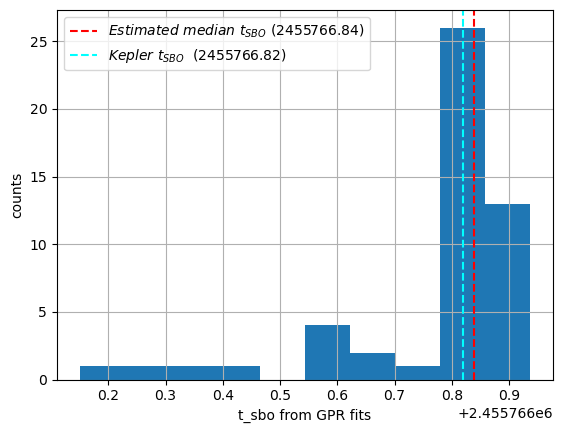

In [40]:
plt.hist(t_sbo_all)
plt.axvline(np.median(t_sbo_all), color='red', linestyle='--',
            label=r"$Estimated\ median\ t_{SBO}\ (" + str(np.median(t_sbo_all).round(2)) + ")$")

plt.axvline(initial_time, color='cyan', linestyle='--',
            label=r"$Kepler\ t_{SBO}\ \ (" + str(initial_time.round(2)) + ")$")
plt.legend()
plt.grid()
plt.xlabel("t_sbo from GPR fits")
plt.ylabel("counts")


## fit with GPR: random discovery time

In [ ]:
### Choice of the discovery time index taken randomly between shock breakout time index+10 and peak lum time index-10
time_index = 10
discovery_times = []
discovery_time_index = random.randint(initial_time_index+time_index, peak_lum_index-time_index) # (0.51, 7.42) days from initial time
discovery_times.append(time[discovery_time_index]-initial_time) # days from t_sbo
t_disc = discovery_times + initial_time

print ("random choose the t_disc = ", t_disc)
print ("It is ",discovery_times, 'after t_sbo ',initial_time )

In [ ]:
### Selected interval for time and flux based on the randomly chosen interval
time_1 = time[discovery_time_index : end_index]
sap_flux_1 = sap_flux[discovery_time_index : end_index]
sap_flux_err_1 = sap_flux_err[discovery_time_index : end_index]

In [ ]:
### Kepler data plot showing above decisions visually
fig, ax = plt.subplots(1,1,figsize=([10,10]))
ax.plot(time, sap_flux/np.max(sap_flux), '.', markersize = 8, color = 'black', label = 'Data Points')
#ax.errorbar(time[discovery_time_index : end_index] - initial_time,sap_flux[discovery_time_index : end_index], yerr = yerr, color = 'blue', label = 'Uncertainty Bars', alpha=0.25)
ax.plot(time_1, sap_flux_1/np.max(sap_flux),'.', color = 'red', label = 'Data Points Chosen') 
plt.vlines(time[discovery_time_index], np.min(sap_flux/np.max(sap_flux)), 1, color='red', label='Discovery time to End of usable dataset')
plt.vlines(time[end_index], np.min(sap_flux/np.max(sap_flux)), 1, color='red')
plt.vlines(initial_time, np.min(sap_flux/np.max(sap_flux)), 1, color='green', label='Shock breakout time to peak luminosity time')
plt.vlines(peak_lum_time, np.min(sap_flux/np.max(sap_flux)), 1, color='green')
plt.hlines(B, np.min(time), np.max(time), color='purple', label='Estimated sap_flux at shock breakout')
#plt.plot([initial_time, time[peak_lum_index]],[B, B+d*rise_time_Kepler], color='magenta', label='First derivative at shock-breakout')
ax.set_xlabel('Julian Date (Days)')
ax.set_ylabel('SAP Flux Normalized (e-/s)')
ax.set_ylim(0.958,1.0005)
ax.set_title('Kepler Light Curve')
ax.grid(which = "both")
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.legend(loc = "lower right")
#plt.savefig('Kepler_data_decisions.png', dpi = 300, bbox_inches = "tight")
plt.show()
plt.close()  

1100


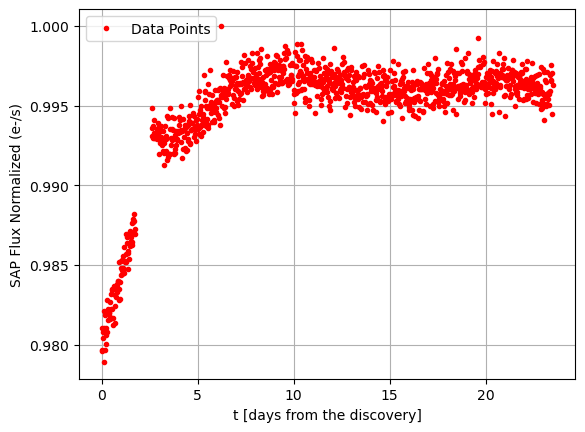

In [21]:
t0 =  time_1.min()
X = time_1 - t0
y = sap_flux_1/np.max(sap_flux)
print (len(X))
plt.plot(X, y,'.', color = 'red', label = 'Data Points') 
plt.xlabel('t [days from the discovery]')
plt.ylabel('SAP Flux Normalized (e-/s)')
plt.legend()
plt.grid()

In [22]:
# ==== Kernel setup ====
kernel = (
    DotProduct(sigma_0=1.0) * C(1.0, (1e-3, 1e3)) +
    C(1.0, (1e-3, 1e3)) * Matern(length_scale=3.0, nu=1.5,
                                 length_scale_bounds=(0.05, 100.0)) +
    WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
)

# ==== Prediction grid ====
X_pred = np.linspace(X.min()-3, X.max()+3, 600).reshape(-1,1)
mjd_pred = X_pred.ravel() + t0

X = X.reshape(-1, 1)

## single fit

In [35]:
gpr = GaussianProcessRegressor(kernel=kernel,
                               normalize_y=True,
                               n_restarts_optimizer=5)
gpr.fit(X, y)
y_pred, _ = gpr.predict(X_pred, return_std=True)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


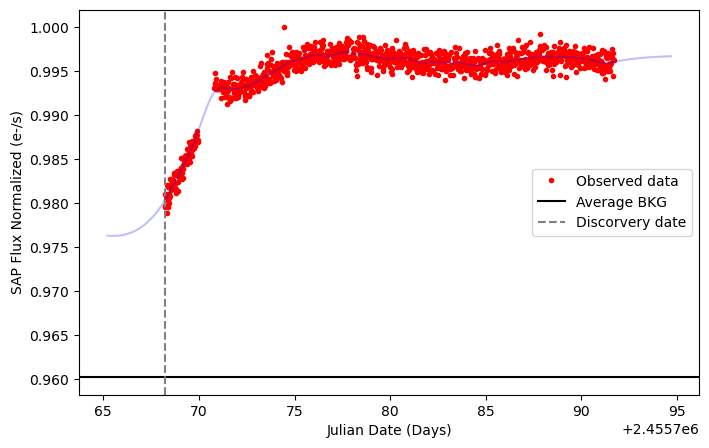

In [36]:
# ==== Plot outside the loop ====
plt.figure(figsize=(8,5))
plt.plot(X+t0, y, 'r.', label='Observed data')
plt.plot(mjd_pred, y_pred, color='blue', alpha=0.25)



plt.axhline(ave_BKG, color='black', linestyle='-',label="Average BKG") 
plt.axvline(t_disc, color='gray', linestyle='--',label="Discorvery date")
#plt.plot (t_sbo,ave_BKG, marker='*', color="yellow",markersize=15, label="t_SBO="+str(t_sbo.round(2)))
plt.xlabel('Julian Date (Days)')
plt.ylabel('SAP Flux Normalized (e-/s)')

plt.legend()

In [27]:

# ==== Jackknife parameters ====
n_iter = 10              # number of jackknife samples
frac_remove = 0.15       # fraction of points to remove each iteration

# ==== Storage lists ====
all_y_pred = []          # to store each run’s y_pred
all_idx_kept = []        # optional: which points were used each run

# ==== Jackknife loop ====
for i in range(n_iter):
    mask = np.ones(len(X), dtype=bool)
    drop_idx = np.random.choice(len(X), size=int(frac_remove*len(X)), replace=False)
    mask[drop_idx] = False

    X_sub, y_sub = X[mask], y[mask]
    all_idx_kept.append(np.where(mask)[0])   # (optional)

    gpr = GaussianProcessRegressor(kernel=kernel,
                                   normalize_y=True,
                                   n_restarts_optimizer=5)
    gpr.fit(X_sub, y_sub)
    y_pred, _ = gpr.predict(X_pred, return_std=True)
    all_y_pred.append(y_pred)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/

In [28]:
# ==== Convert to array for later analysis ====
all_y_pred = np.array(all_y_pred)   # shape (n_iter, len(X_pred))

# ==== Example: compute jackknife mean and std ====
jack_mean = np.mean(all_y_pred, axis=0)
jack_std  = np.std(all_y_pred, axis=0)

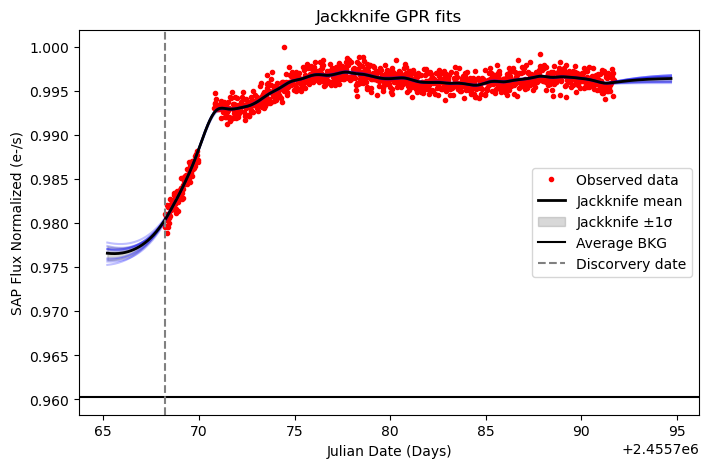

In [34]:
# ==== Plot outside the loop ====
plt.figure(figsize=(8,5))
plt.plot(X+t0, y, 'r.', label='Observed data')
for y_pred in all_y_pred:
    plt.plot(mjd_pred, y_pred, color='blue', alpha=0.25)

plt.plot(mjd_pred, jack_mean, 'k-', lw=2, label='Jackknife mean')
plt.fill_between(mjd_pred, jack_mean - jack_std, jack_mean + jack_std,
                 color='gray', alpha=0.3, label='Jackknife ±1σ')

plt.axhline(ave_BKG, color='black', linestyle='-',label="Average BKG") 
plt.axvline(t_disc, color='gray', linestyle='--',label="Discorvery date")
#plt.plot (t_sbo,ave_BKG, marker='*', color="yellow",markersize=15, label="t_SBO="+str(t_sbo.round(2)))
plt.xlabel('Julian Date (Days)')
plt.ylabel('SAP Flux Normalized (e-/s)')

plt.legend()
plt.title('Jackknife GPR fits')
plt.show()

In [32]:
ave_BKG = B
t_sbo_norm = mjd_pred[np.argmin(np.abs(y_pred - ave_BKG ))][0]
mag_sbo = y_pred[np.argmin(np.abs(y_pred - ave_BKG ))]

IndexError: invalid index to scalar variable.